Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "" # put your full name here
COLLABORATORS = [] # list anyone you collaborated with on this workbook

---

## Lab 6: Multiple Regression

-------------------------------------------

Welcome to your sixth lab of the semester!<br>

This lab continues to build on the spatial analysis and modeling skills we have been developing in previous assignments. Specifically, we will use Geopandas and the `statsmodels` library to try to predict the area burned by large wildfires in the Sierra Nevada region of California. 

Feel free to refer to Lab 3 for the basic Geopandas methods we learned a few weeks ago, and to Lab 5 for linear regression (single variable) basics. 

## Setup & Review

Let's begin by importing the packages we'll need.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

%matplotlib inline

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


The first dataset we will examine is fire perimeter data from the [Monitoring Trends in Burn Severity (MTBS)](https://www.mtbs.gov/project-overview) database. The data are stored as shapefiles in the `data/mtbs_ca` folder. To reduce the file size, we pre-processed the original nationwide data to only include data for the Sierra Nevada region (as defined by [the Sierra Nevada Conservancy boundary](https://gis.data.ca.gov/datasets/f147fdc76a104484b9fa90baacf9462f_0?geometry=-133.799%2C35.544%2C-106.047%2C41.552)). The raw MTBS data includes information about prescribed fires and wildfires; in this lab, we have filtered out all fire types except for wildfires. 

**Question 1 (1pt):** Import the shapefile as a GeoDataFrame. Print the first few rows. 

In [3]:
# YOUR CODE HERE
sn_wildfires = ...
sn_wildfires

Ellipsis

In [14]:
# YOUR CODE HERE
sn_wildfires = gpd.read_file('data/mtbs_sn/mtbs_sn.shp')
sn_wildfires.head()

,Fire_ID,Fire_Name,Year,StartMonth,StartDay,Fire_Type,Acres,geometry
0,CA3525911854920000802,PEAK,2000,8,2,Wildfire,1316.0,"POLYGON ((-118.56981 35.26986, -118.56964 35.2..."
1,CA3534111823820120810,JAWBONE COMPLEX,2012,8,10,Wildfire,12212.0,"MULTIPOLYGON (((-118.22539 35.30764, -118.2253..."
2,CA3541611826720060805,COTTONWOOD,2006,8,5,Wildfire,2386.0,"POLYGON ((-118.29174 35.41341, -118.29188 35.4..."
3,CA3543011843920030723,BASIN,2003,7,23,Wildfire,1051.0,"POLYGON ((-118.42060 35.43559, -118.41990 35.4..."
4,CA3545811870719850628,RICH BAR,1985,6,28,Wildfire,8141.0,"POLYGON ((-118.74454 35.48176, -118.74371 35.4..."


Let's do an abbreviatd EDA on `sn_wildfire`, focusing on granularity and scope. The documentation above indicates that the MTBS data include all fires that burned >= 1000 acres in the western U.S. and >=500 acres in the eastern U.S (reminder that we filtered the full dataset to focus only on the Sierra Nevada region). All land ownerships are included.

Each record in `sn_wildfire` represents a unique fire incident. Take a look at the shape of the geodataframe. How many fire records do we have?

In [15]:
sn_wildfires.shape

(420, 8)

We can see that the data are recorded according to the start date of the fire; we know the year, month, and day of each incident. To determine temporal scope, we can examine the Year column.

In [16]:
sn_wildfires.sort_values(by = 'Year')['Year'].unique() # sort our data frame by year, then find the unique years

array([1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])

Since we are working with spatial data, we also want to identify the coordinate reference system (CRS) in which our data are recorded.

In [17]:
sn_wildfires.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

Finally, let's check the `geometry` column and determine the types of geometries contained in our geodataframe.

In [9]:
sn_wildfires.geometry.geom_type.unique()

array(['Polygon', 'MultiPolygon'], dtype=object)

## More handy Geopandas operations

Geopandas provides a veritable treasure trove of [methods and attributes for Geoseries](https://geopandas.org/docs/reference/geoseries.html#general-methods-and-attributes). As a reminder, in a GeoDataFrame, a Geoseries is the column that contains the `geometry` attribute. That column is often, but not always, named "geometry". 

In our `sn_wildfire` dataframe, each geometry represents the perimeter of the area burned by a wildfire incident. We can use Geopandas operations to explore different properties of these geometries. 

For example, we might want to know the **centroid** of each burned area:

In [10]:
sn_wildfires.geometry.centroid.head()

# equivalently, we could have called sn_wildfires['geometry'].centroid

/tmp/ipykernel_51/3291928805.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sn_wildfires.geometry.centroid.head()


0    POINT (-118.54871 35.25947)
1    POINT (-118.22728 35.28013)
2    POINT (-118.26734 35.41600)
3    POINT (-118.43934 35.43035)
4    POINT (-118.70713 35.45845)
dtype: geometry

**Question 2 (1 pt):** Your centroid call probably returned the following warning:  
`Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.`

Why does Python give you this warning? What are the units of area and length returned by the Geopandas built-in methods? *Hint:* it might be helpful to [look up the CRS](https://epsg.org/home.html) for this dataset. 

*YOUR ANSWER HERE*

*SOLUTION*


*The units of measure depend on the CRS! In this case, we are working the NAD83 projection, whose unit of measurement is the degree. So, our area is expressed in radian degrees squared, and our perimeter in radian degrees. Not very intuitive units in which to work! If we wanted to remove the warning, we could reproject our dataframe into an equal area or equal distance CRS.*

**Question 3 (1pt):** Transform the `sn_wildfires` data to the CONUS Albers equal area projection (EPSG:5070), which uses the meter as its unit of measure.

In [11]:
# YOUR CODE HERE
sn_wildfires = ...

In [18]:
# SOLUTION
sn_wildfires = sn_wildfires.to_crs(epsg=5070)

In this lab, we will try to predict the area burned by a wildfire (using `Acres` as our response variable), using start month and (relative) distance to the nearest highway as independent variables. For the latter, we will need [data on the locations of primary roads (i.e., interstates and highways) in the U.S](https://catalog.data.gov/dataset/tiger-line-shapefile-2016-nation-u-s-primary-roads-national-shapefile). 

**Question 4 (1pt):** Open the shapefile in `data/tl_2016_us_primaryroads/` as a GeoDataFrame named ` sn_roads`. If needed, transform the CRS to match that of `sn_wildfires`.

In [10]:
# YOUR CODE HERE
sn_roads = ...

In [19]:
# SOLUTION
sn_roads = gpd.read_file('data/tl_2016_us_primaryroads/tl_2016_us_primaryroads_sn.shp')
print(sn_roads.crs)
sn_roads = sn_roads.to_crs(epsg=5070)

epsg:4269


Take a look at the records in `sn_roads`. In this case, roads are represented as Linestrings. Each record represents a segment of a state or interstate highway that intersects with the Sierra Nevada boundary.

In [20]:
print(sn_roads.geometry.geom_type.unique())
print(sn_roads.shape)
sn_roads

['LineString']
(12, 5)


,LINEARID,FULLNAME,RTTYP,MTFCC,geometry
0,1102217388786,I- 80,I,S1100,"LINESTRING (-2064708.872 2077283.613, -2064680..."
1,110434220835,I- 80,I,S1100,"LINESTRING (-2025812.726 2082080.386, -2025796..."
2,110434220836,I- 80,I,S1100,"LINESTRING (-2025825.442 2082083.668, -2025770..."
3,110809146095,State Rte 89,S,S1100,"LINESTRING (-2045555.944 2073081.664, -2045550..."
4,110687705699,State Rte 193,S,S1100,"LINESTRING (-2129501.978 2046312.604, -2129505..."
5,1104259561602,State Rte 193,S,S1100,"LINESTRING (-2134389.618 2045060.711, -2134356..."
6,1103017265103,I- 80,I,S1100,"LINESTRING (-2080238.906 2081293.806, -2080207..."
7,1104469669293,I- 80,I,S1100,"LINESTRING (-2064561.777 2077245.397, -2064084..."
8,1104748193081,I- 80,I,S1100,"LINESTRING (-2074601.090 2079823.305, -2074571..."
9,1104748193082,I- 80,I,S1100,"LINESTRING (-2074601.090 2079823.305, -2074624..."


**Question 5 (1pt):** Use Geopandas operations to find the length of each road in `sn_roads`.

In [21]:
# YOUR CODE HERE

In [22]:
# YOUR CODE HERE
sn_roads.geometry.length

0     50093.702962
1      2687.106153
2      2715.134362
3      3872.369901
4      5198.777313
5      5205.853580
6      7295.653778
7     49986.419038
8     11371.331226
9      6337.284092
10    11076.429869
11     3877.501274
dtype: float64

Geopandas can also calculate the distance between geometries. The code below finds the nearest distance between each road in `sn_roads` and the centroid of the first wildfire listed in `sn_wildfires`. 

In [23]:
dsts = sn_roads.distance(sn_wildfires.centroid.loc[0])
dsts

0     477841.988893
1     486168.349063
2     486171.910832
3     477841.988893
4     464136.715076
5     464121.117097
6     487393.686756
7     477819.330430
8     483748.749938
9     487436.156137
10    483801.819765
11    477819.330430
dtype: float64

**Question 6 (1 pt):** Write a function `min_distance` that takes in a single Point geometry ("point") and a series of Linestring geometries ("lines") and returns the distance (in kilometers) between that point and the nearest line.

In [24]:
# YOUR CODE HERE
def min_distance(point, lines):
    return ...

In [25]:
# SOLUTION
def min_distance(point, lines):
    return lines.distance(point).min()/1000

In [26]:
assert min_distance(sn_wildfires.centroid[0], sn_roads) == dsts.min()/1000

**Question 7 (1 pt):** Using your `min_distance` function, add a new column to `sn_wildfires`, each of whose elements represents the distance between the centroid of the burned area and the nearest major road in `sn_roads`. Name this column "dst_to_rd."

In [27]:
# YOUR CODE HERE

In [28]:
# SOLUTION
sn_wildfires['dist_to_rd']=[min_distance(sn_wildfires.centroid[i],sn_roads) for i in sn_wildfires.index]

In [29]:
sn_wildfires

,Fire_ID,Fire_Name,Year,StartMonth,StartDay,Fire_Type,Acres,geometry,dist_to_rd
0,CA3525911854920000802,PEAK,2000,8,2,Wildfire,1316.000000,"POLYGON ((-2016700.220 1597606.920, -2016677.0...",464.121117
1,CA3534111823820120810,JAWBONE COMPLEX,2012,8,10,Wildfire,12212.000000,"MULTIPOLYGON (((-1985512.433 1594466.258, -198...",476.441597
2,CA3541611826720060805,COTTONWOOD,2006,8,5,Wildfire,2386.000000,"POLYGON ((-1988579.821 1607368.550, -1988579.8...",461.578551
3,CA3543011843920030723,BASIN,2003,7,23,Wildfire,1051.000000,"POLYGON ((-1999281.139 1612486.518, -1999225.3...",452.233765
4,CA3545811870719850628,RICH BAR,1985,6,28,Wildfire,8141.000000,"POLYGON ((-2026392.343 1624370.373, -2026325.3...",437.750161
...,...,...,...,...,...,...,...,...,...
415,CA3978012014320170806,CHILCOOT,2017,8,6,Wildfire,1032.032282,"POLYGON ((-2027754.953 2119669.096, -2027778.7...",36.804625
416,CA3990612097220170729,MINERVA 5,2017,7,29,Wildfire,4545.743496,"POLYGON ((-2087598.917 2153628.788, -2087551.2...",70.668710
417,CA4039512024220170829,MUD,2017,8,29,Wildfire,6041.121008,"POLYGON ((-2014780.127 2197153.280, -2014740.4...",110.278633
418,CA4130712105620170725,COVE,2017,7,25,Wildfire,30884.670066,"POLYGON ((-2052233.708 2308337.344, -2052187.4...",219.984051


## Multi-Variable Regression

In addition to distance to the nearest highway, we want to use the month in which the fire starts as an independent variable. Before we fit a regression model, let's visualize the data and qualitatively try to identify any patterns or trends that emerge between our independent and dependent variables. 

**Question 8 (1 pt):** Run the code below to generate a pair of scatter plots showing the relationship between `Acres` burned (the target variable, represented on the y-axis), and each of the independent variables (`StartMonth` and `dist_to_rd`, represented on the x-axes). What trends do you notice? 

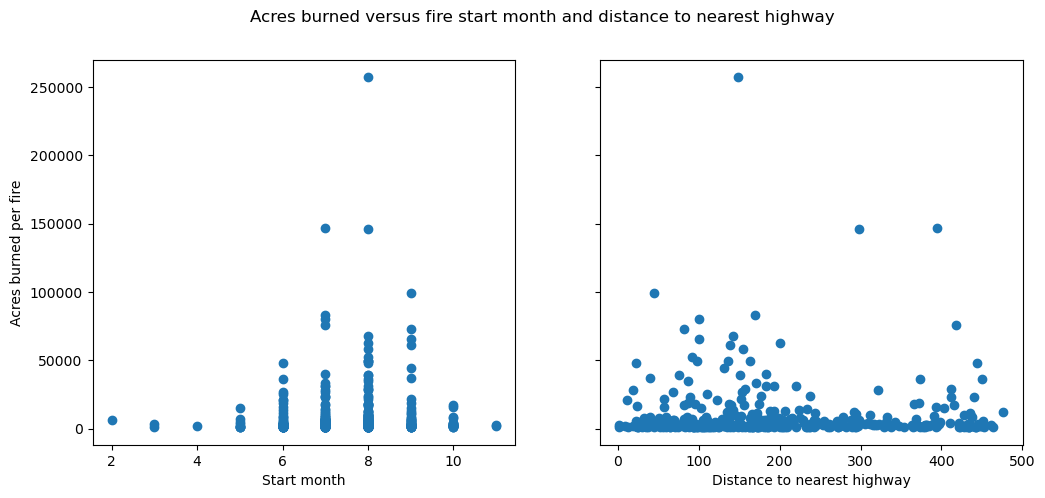

In [30]:
# This time using a logarithmic scale for area burned
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(12,5))

ax0.scatter(sn_wildfires['StartMonth'],sn_wildfires['Acres'])
ax0.set_xlabel('Start month')
ax0.set_ylabel('Acres burned per fire')

ax1.scatter(sn_wildfires['dist_to_rd'],sn_wildfires['Acres'])
ax1.set_xlabel('Distance to nearest highway')

plt.suptitle('Acres burned versus fire start month and distance to nearest highway');

*YOUR OBSERVATION HERE*

*We can already see that the data are pretty noisy, making it difficult to identify clear trends. There seems to be somewhat of a trend of burned area peaking around months 7-8, and area burned seems to decrease somewhat as distance to the nearest highways grows.*

We are ready at last to create our linear regression model, using **two features** (start month and distance to nearest highway) to predict acres burned. 

This time, instead of `scikit-learn`, we'll use a library called `statsmodels`. One nice feature of `statsmodels` is its clean, informative summary of regression results and statistics.

In [31]:
# Run this cell to import the statsmodels library
import statsmodels.api as sm

Estimating a model with `statsmodels` uses a similar process to model estimation in `scikit-learn`. We first initialize a model, in this case using the `sm.OLS()` method, which takes **X** and **y** (in dataframe form) as arguments. We then `.fit()` the model and can view information about the coefficients and model performance using `.summary()`. 

**Question 9 (1pt):** Create a dataframe **X**, which holds our two independent variables, each as a column of observations. In addition, create a dataframe **y** that holds the response variable.

In [23]:
# YOUR CODE HERE
X = ...
y = ...

In [32]:
# SOLUTION
X = sn_wildfires.loc[:,['dist_to_rd','StartMonth']]
y = sn_wildfires[['Acres']]

Unlike `scikit-learn`, statsmodels expects a column of 1's in the **X** dataframe in order to fit an intercept. One way to achieve this is to apply `statsmodel`'s built-in `add_constant` function to your dataframe of **X** values.

In [33]:
# run this cell
X_const = sm.add_constant(X)
X_const.head()

,const,dist_to_rd,StartMonth
0,1.0,464.121117,8
1,1.0,476.441597,8
2,1.0,461.578551,8
3,1.0,452.233765,7
4,1.0,437.750161,6


Run the cell below to fit a model to **X** and **y** and view the results.

In [34]:
# Run this cell
sn_wf_model = sm.OLS(y,X_const)
sn_wf_results = sn_wf_model.fit()
sn_wf_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Acres   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9329
Date:                Tue, 03 Oct 2023   Prob (F-statistic):              0.394
Time:                        13:50:58   Log-Likelihood:                -4767.3
No. Observations:                 420   AIC:                             9541.
Df Residuals:                     417   BIC:                             9553.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        982.9900   6773.586      0.145      0.885   -1.23e+04    1.43e+04
dist_to_rd    -0.5710      8.307     -0.069      0.945     -16.900      15.758
StartMonth  1124.7097    837.103      1.344      0.180    -520.759    2770.178
==============================================================================
Omnibus:                      552.815   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63619.373
Skew:                           6.449   Prob(JB):                         0.00
Kurtosis:                      61.898   Cond. No.                     1.57e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Question 10 (1pt):** What are the values and 95% confidence intervals of the three coefficients? What do the confidence intervals imply about the model we've built?

*YOUR ANSWER HERE* 

*The confidence intervals are extremely wide and include 0. This means there is a >5% probability that there is actually no relationship between our independent and dependent variables.*

## Feature Engineering

Let's try to improve our model by adding more features. Instead of using new sources of data, we will transform the two independent variables we already have and add these transformations as additional features. This process is known as "feature engineering."

**Question 11 (1pt)** To make it easy to test different sets of features, write a function `fit_OLS` that takes in a dataframe containing the independent variables ($X$) and another dataframe containing response variable ($y$). The function should fit a linear regression model and output the `statsmodels` summary for the model. Feel free to use the code in the previous section as a template. Test your model on the $X$ and $y$ dataframes you created in Question 9.

In [ ]:
# Replace ellipses with your code* 

def fit_OLS(X,y):
    X_const = sm.add_constant(...)
    ols_model = sm.OLS(...)
    results = ...
    return results.summary()

In [35]:
# SOLUTION 

def fit_OLS(X,y):
    X_const = sm.add_constant(X)
    ols_model = sm.OLS(y,X_const)
    results = ols_model.fit()
    return results.summary()

In [36]:
fit_OLS(X,y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Acres   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9329
Date:                Tue, 03 Oct 2023   Prob (F-statistic):              0.394
Time:                        13:51:45   Log-Likelihood:                -4767.3
No. Observations:                 420   AIC:                             9541.
Df Residuals:                     417   BIC:                             9553.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        982.9900   6773.586      0.145      0.885   -1.23e+04    1.43e+04
dist_to_rd    -0.5710      8.307     -0.069      0.945     -16.900      15.758
StartMonth  1124.7097    837.103      1.344      0.180    -520.759    2770.178
==============================================================================
Omnibus:                      552.815   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63619.373
Skew:                           6.449   Prob(JB):                         0.00
Kurtosis:                      61.898   Cond. No.                     1.57e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The first new feature we will add to our model is the natural log of the `dist_to_rd` variable. The code block below provides an approach to expanding our $X$ dataframe to include this new feature.

In [37]:
X['log_dist'] = np.log(sn_wildfires['dist_to_rd'])
X.head()

,dist_to_rd,StartMonth,log_dist
0,464.121117,8,6.140146
1,476.441597,8,6.166345
2,461.578551,8,6.134652
3,452.233765,7,6.114199
4,437.750161,6,6.081648


**Question 12 (2pts)** Add two more features to $X$: a) the `StartMonth` variable squared, and b) `dist_to_rd`/`StartMonth`.   

*Note:* These new features don't necessarily have any intuitive meaning in the real world. We're just experimenting to see if we can come up with some new transformations that improve our model's performance. Since we are focusing on prediction and not inference, we don't have to understand the physical reasons why a particular transformation might work or not.

In [38]:
# YOUR ANSWER HERE


In [39]:
# YOUR ANSWER HERE

X['month^2'] = sn_wildfires['StartMonth']**2
X['dist/month'] = sn_wildfires['dist_to_rd']/sn_wildfires['StartMonth']
X.head()

,dist_to_rd,StartMonth,log_dist,month^2,dist/month
0,464.121117,8,6.140146,64,58.015140
1,476.441597,8,6.166345,64,59.555200
2,461.578551,8,6.134652,64,57.697319
3,452.233765,7,6.114199,49,64.604824
4,437.750161,6,6.081648,36,72.958360


**Question 13 (1pt)** Use your `fit_OLS` function to estimate a model for your expanded $X$ feature set. Did the addtion of the transformed features improve the model? *Hint:* compare the AIC value for the model you estimated in the previous section to this one.

In [40]:
# YOUR CODE HERE

In [41]:
# SOLUTION
fit_OLS(X,y)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Acres   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.695
Date:                Tue, 03 Oct 2023   Prob (F-statistic):              0.135
Time:                        13:51:57   Log-Likelihood:                -4764.0
No. Observations:                 420   AIC:                             9540.
Df Residuals:                     414   BIC:                             9564.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.031e+05   4.12e+04     -2.503      0.013   -1.84e+05   -2.21e+04
dist_to_rd   -90.0631     42.734     -2.108      0.036    -174.067      -6.060
StartMonth  2.529e+04   9625.847      2.627      0.009    6364.085    4.42e+04
log_dist    1415.6409   2609.532      0.542      0.588   -3713.945    6545.226
month^2    -1437.7676    576.271     -2.495      0.013   -2570.549    -304.986
dist/month   591.4309    276.922      2.136      0.033      47.083    1135.779
==============================================================================
Omnibus:                      551.103   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63408.209
Skew:                           6.411   Prob(JB):                         0.00
Kurtosis:                      61.813   Cond. No.                     1.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

*YOUR ANSWER HERE*

*We did improve our model (AIC decreased by 1), but it's still pretty bad!*

**Question 14 (1pt):** Besides feature engineering, what else might you be able to do to build a model that better predicts burned area in the Sierra Nevada?

*YOUR ANSWER HERE*

*Answers may vary, but some ideas include: adding features based on other data sources (e.g., vegetation type, time since last fire,...), transforming the CRS to get more accurate measurements of centroid and distance, further narrowing the regional scope (e.g., to only look at mixed conifer ecosystems in the Sierra Nevada), etc.*

**EXTRA CREDIT (2pts):** Take a stab at engineering at least one new feature of your own, using different transformations and/or combinations of the features in the $X$ dataframe. Fit your model and view the results. Did your new feature(s) improve the model? (1 pt for attempting this problem; 1 pt for improving AIC over our baseline.)

In [42]:
# YOUR CODE HERE

*YOUR ANSWER HERE*

# Hooray, you're done! 

Please remember to submit your lab work, after clicking Kernel -> Restart & Run All, in .pdf and .ipynb format on bCourses.